In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/valid/VMD__1813_jpg.rf.d7a051f947c29770e6ec7f3d660fd14b.jpg
/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/valid/ND__606_jpg.rf.e9f6304cbb4b38aa2456bff004ea0a69.jpg
/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/valid/ND__2652_jpg.rf.b9cabd116edca3ce83a6149e17c28d13.jpg
/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/valid/VMD__1541_jpg.rf.bbd08f176082dfd241be1d85225e4096.jpg
/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/valid/ND__1686_jpg.rf.aecf5428bd4e36004f3a4782f2af0e53.jpg
/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/valid/ND__912_jpg.rf.b32358927dd91449e670427d4cf4a564.jpg
/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/valid/MD__614_jpg.rf.20c02d0a935f7e5767ea5e492070231e.jpg
/kaggle/input/alzheimers-classification-dataset/A

In [3]:
#Importing Libraries

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from keras.preprocessing import image

import warnings
warnings.filterwarnings('ignore')

print("Imported libraries successfully")

2025-08-31 11:03:31.540627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756638211.904786      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756638212.010604      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Imported libraries successfully


In [4]:
#Defining dataframe paths.

train_df = pd.read_csv("/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/CSV_datafiles/_train_classes.csv")
valid_df = pd.read_csv("/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/CSV_datafiles/_valid_classes.csv")
test_df = pd.read_csv("/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/CSV_datafiles/_test_classes.csv")

print(train_df.head(5))
print(valid_df.head(5))
print(test_df.head(5))

                                            filename  MD  MoD  ND  VMD
0  ND__2350_jpg.rf.f80ac7f889639a124e46a6161c6ead...   0    0   1    0
1  ND__2410_jpg.rf.6187777801c05a159fb8b3fbfb803f...   0    0   1    0
2  VMD__1300_jpg.rf.4d7c333b0db31734bc8aab97e1ceb...   0    0   0    1
3  VMD__1315_jpg.rf.71636662b292c60ca022a1efbc8f5...   0    0   0    1
4  ND__2408_jpg.rf.53fc1d9575791ead9974991dd8cbc4...   0    0   1    0
                                            filename  MD  MoD  ND  VMD
0  VMD__2048_jpg.rf.470f08a30da65e653f11a619183e0...   0    0   0    1
1  VMD__2066_jpg.rf.d68949be3d2257e9eaf5aa0ce7fcc...   0    0   0    1
2  VMD__2061_jpg.rf.3b5057d8e1c164781e26bdb5f13c1...   0    0   0    1
3  VMD__2046_jpg.rf.853ccded56f6b0fc2d335176c99fd...   0    0   0    1
4  VMD__2051_jpg.rf.32e601439d9c0880361f96a09ffe8...   0    0   0    1
                                            filename  MD  MoD  ND  VMD
0  VMD__214_jpg.rf.e1b1f4a83fae251bbd6503a616ec46...   0    0   0    1
1  VMD

In [5]:
## Converting one-hot encoding values into labels for easy Data Aug.
class_columns = ['MD', 'MoD', 'ND', 'VMD']

for df in [train_df, valid_df, test_df]:
    df['label'] = df[class_columns].idxmax(axis = 1)

print(train_df[['filename', 'label']].head(5))

                                            filename label
0  ND__2350_jpg.rf.f80ac7f889639a124e46a6161c6ead...    ND
1  ND__2410_jpg.rf.6187777801c05a159fb8b3fbfb803f...    ND
2  VMD__1300_jpg.rf.4d7c333b0db31734bc8aab97e1ceb...   VMD
3  VMD__1315_jpg.rf.71636662b292c60ca022a1efbc8f5...   VMD
4  ND__2408_jpg.rf.53fc1d9575791ead9974991dd8cbc4...    ND


In [6]:
## Data Augmentation and things...

#Already performed the following things.
# Preprocessing:
    #Auto-Orient: Applied
    #Resize: Stretch to 224x224

# Augmentation:
    #Outputs per training example: 2
    #Flip: Horizontal, Vertical
    #Rotation: Between -15° and +15°

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

## Define image folder paths.
train_images_path = "/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/train"
valid_images_path = "/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/valid"
test_images_path = "/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/test"


# Only preprocessing step u need.
gen = ImageDataGenerator(
    rescale = 1./255
)

# Writing Generators.

train_gen = gen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_images_path,
    x_col = 'filename',
    y_col = 'label',
    color_mode = "rgb",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42
)

valid_gen = gen.flow_from_dataframe(
    dataframe = valid_df,
    directory = valid_images_path,
    x_col = 'filename',
    y_col = 'label',
    color_mode = "rgb",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = 42
)

test_gen = gen.flow_from_dataframe(
    dataframe = test_df,
    directory = test_images_path,
    x_col = 'filename',
    y_col = 'label',
    color_mode = "rgb",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = 42
)

Found 8960 validated image filenames belonging to 4 classes.
Found 1280 validated image filenames belonging to 4 classes.
Found 640 validated image filenames belonging to 4 classes.


In [8]:
IMAGE_SIZE = 224
NUM_CLASSES = 4
COLOR_CHNL = 3

base_model = tf.keras.applications.ResNet152(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, COLOR_CHNL)
)
base_model.trainable = False

'''
# Unfreezing model's top 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
'''


input_tensor = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, COLOR_CHNL))
output_tensor = base_model(input_tensor)

# Using sequential model architecture
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
print("Model building successful")

I0000 00:00:1756638243.022680      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756638243.023360      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model building successful


In [9]:
## Compiling the model

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print("Model compilation complete")

Model compilation complete


In [10]:
## Summary of the model.

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)               │ (None, 7, 7, 2048)          │      58,370,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,600,964 (227.36 MB)

 Trainable params: 1,225,924 (4.68 MB)

 Non-trainable params: 58,375,040 (222.68 MB)

In [11]:
## Writing callbacks

earlystop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    min_delta = 0.001,
    restore_best_weights = True,
    verbose = 1
)

In [15]:
## Initial training before fine tuning.
batch_size=32
STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size

# fit model
history = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[earlystop])

Epoch 1/25
280/280 ━━━━━━━━━━━━━━━━━━━━ 76s 269ms/step - accuracy: 0.9021 - loss: 0.2474 - val_accuracy: 0.9031 - val_loss: 0.3039
Epoch 2/25
280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.9184 - loss: 0.2071 - val_accuracy: 0.8930 - val_loss: 0.3447
Epoch 3/25
280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.9074 - loss: 0.2310 - val_accuracy: 0.9023 - val_loss: 0.2934
Epoch 4/25
280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 265ms/step - accuracy: 0.9310 - loss: 0.1858 - val_accuracy: 0.9203 - val_loss: 0.2717
Epoch 5/25
280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 262ms/step - accuracy: 0.9286 - loss: 0.1743 - val_accuracy: 0.9102 - val_loss: 0.3246
Epoch 6/25
280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.9359 - loss: 0.1633 - val_accuracy: 0.9211 - val_loss: 0.3003
Epoch 7/25
280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 262ms/step - accuracy: 0.9435 - loss: 0.1551 - val_accuracy: 0.9141 - val_loss: 0.3422
Epoch 8/25
280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.9460 - loss: 0

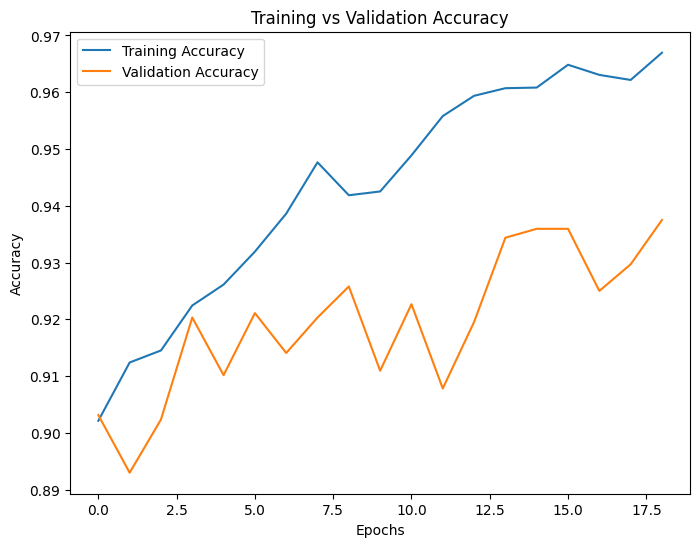

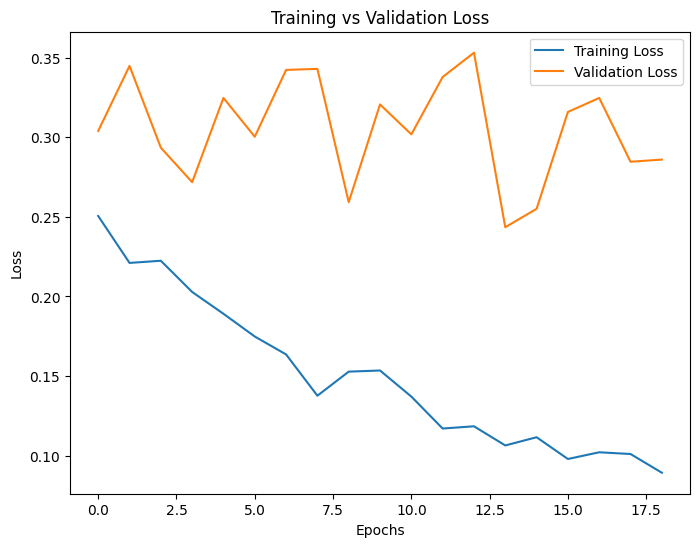

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss (optional)
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9438 - loss: 0.2486
Test Accuracy: 94.22%
Test Loss: 0.2209
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step

Classification Report:
              precision    recall  f1-score   support

          MD       0.94      0.90      0.92        86
         MoD       1.00      1.00      1.00         5
          ND       0.95      0.97      0.96       319
         VMD       0.93      0.93      0.93       230

    accuracy                           0.94       640
   macro avg       0.95      0.95      0.95       640
weighted avg       0.94      0.94      0.94       640



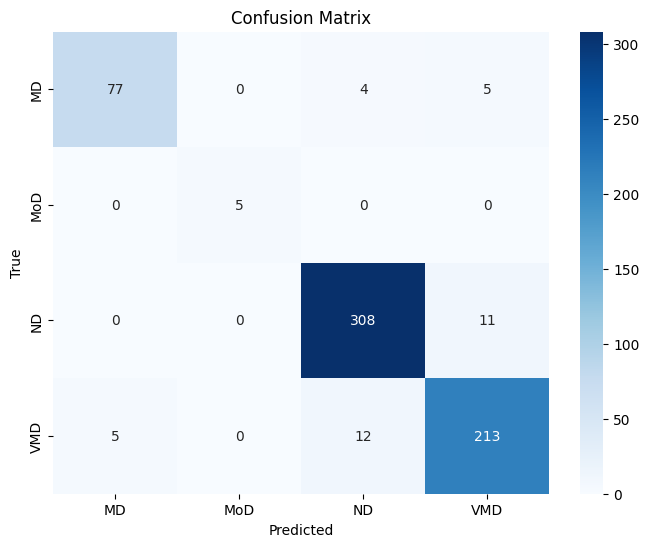

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)   # predicted labels
y_true = test_gen.classes                    # true labels
class_labels = list(test_gen.class_indices.keys())  # class names

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [13]:
#model.save("myalzh_model.h5")

In [14]:
'''
from PIL import Image
model = tf.keras.models.load_model("/kaggle/working/alz_model.h5")

# Test image
img = Image.open("/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/test/VMD__1021_jpg.rf.6aa9d1ae0abff9b286b8d63547b07c5c.jpg").convert("RGB")
img = img.resize((224, 224))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Get prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
confidence = predictions[0][predicted_class_index]

print(f"Predicted class index: {predicted_class_index}")
print(f"Confidence: {confidence}")
print(f"All predictions: {predictions[0]}")
'''

'\nfrom PIL import Image\nmodel = tf.keras.models.load_model("/kaggle/working/alz_model.h5")\n\n# Test image\nimg = Image.open("/kaggle/input/alzheimers-classification-dataset/Alzheimers_Detection_dataset/test/VMD__1021_jpg.rf.6aa9d1ae0abff9b286b8d63547b07c5c.jpg").convert("RGB")\nimg = img.resize((224, 224))\nimg_array = np.array(img) / 255.0\nimg_array = np.expand_dims(img_array, axis=0)\n\n# Get prediction\npredictions = model.predict(img_array)\npredicted_class_index = np.argmax(predictions[0])\nconfidence = predictions[0][predicted_class_index]\n\nprint(f"Predicted class index: {predicted_class_index}")\nprint(f"Confidence: {confidence}")\nprint(f"All predictions: {predictions[0]}")\n'